In [0]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [24]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install gym[box2d] > /dev/null 2>&1

Requirement already up-to-date: setuptools in /tensorflow-2.1.0/python3.6 (45.2.0)


In [1]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
%tensorflow_version 2.x
import tensorflow as tf
import numpy as np
import random
import time
from datetime import timedelta
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import glob
import io
import base64
from IPython.display import HTML

from collections import deque

from IPython import display as ipythondisplay
np.random.seed(0)

TensorFlow 2.x selected.


In [2]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

xdpyinfo was not found, X start can not be checked! Please install xdpyinfo!


<Display cmd_param=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1019'] cmd=['Xvfb', '-br', '-nolisten', 'tcp', '-screen', '0', '1400x900x24', ':1019'] oserror=None return_code=None stdout="None" stderr="None" timeout_happened=False>

In [0]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

# CartPole v0

### Replay Memory

The class to hold the buffer memory for training.

In [0]:
class ReplayMemory:
  def __init__(self, max_mem, batch_size):
    self.max_mem = max_mem
    self.batch_size = batch_size
    self.mem = deque(maxlen=self.max_mem)

  def push(self, state, action, reward, next_state, done):
    self.mem.append((state, action, reward, next_state, (not done)))
  
  def sample(self, num_actions):
    minibatch = np.array(random.sample(self.mem, min(self.batch_size, len(self.mem))))
    state = np.array(list(minibatch[:, 0]))
    action = np.array(list(minibatch[:, 1]))
    action = tf.keras.utils.to_categorical(action, num_classes=num_actions)
    reward = np.array(list(minibatch[:, 2])).reshape(-1, 1)
    next_state = np.array(list(minibatch[:, 3]))
    done = np.array(list(minibatch[:, 4])).astype(float).reshape(-1, 1)

    reward = reward * action
    done = done * action

    return state, reward, next_state, done

### Agent
The agent responsible for the interaction with the environment. This class also contains the 2 models (neural networks i.e. q net and target).

In [0]:
class Agent:
  def __init__(self, input_shape, output_shape):
    self.q_model = self._build_model('Q Model', input_shape, output_shape)
    self.target_q_model = self._build_model('Target Q Model', input_shape, output_shape)

  def _build_model(self, name, input_shape, output_share):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(128, input_shape=input_shape, activation=tf.nn.relu),
      tf.keras.layers.Dense(32, activation=tf.nn.relu),
      tf.keras.layers.Dense(output_share)                               
    ])

  def get_action_probs(self, state, tau):
    action_vals = self.q_model(state.reshape(1, -1))[0]
    action_vals /= tau
    return tf.nn.softmax(action_vals).numpy().astype(np.float32)

  def select_action(self, state, tau=1.0):
    action_probs = self.get_action_probs(state, tau)
    return np.random.choice(env.action_space.n, p=action_probs)

  def save(self, fname):
    self.q_model.save(f'{fname}-q-model.h5')
    self.q_model.save(f'{fname}-q-model-weights.h5')

In [0]:
def count():
  num = 0
  while True:
    num += 1
    yield num

### Hyperparameters
Set the hyperparameters for the training.

In [0]:
ENV_NAME = 'CartPole-v0'

REPLAY_MEM_SIZE = 100000
BATCH_SIZE = 512

NUM_EPISODES = 100
TARGET_UPDATE = 10

LEARNING_RATE = 1e-3
GAMMA = 0.999
TAU_MAX = 4.0
TAU_MIN = -3.0

In [0]:
env = gym.make(ENV_NAME)
env.seed(0)

replay_mem = ReplayMemory(REPLAY_MEM_SIZE, BATCH_SIZE)
agent = Agent(env.observation_space.shape, env.action_space.n)

tf.keras.backend.set_floatx('float64')

### Training
The main training code.

In [12]:
optimizer = tf.keras.optimizers.Adam(lr=LEARNING_RATE)
loss = tf.keras.losses.MeanSquaredError()
agent.q_model.compile(loss=loss, optimizer=optimizer)
running_mean = None
running_mean_steps = None
mean_over = 10 / NUM_EPISODES
timesteps = []
mean_steps = []
means = []
rewards = []
TAU_DECAY = (TAU_MAX - TAU_MIN) / NUM_EPISODES

print(f'Mean Over: {1 / mean_over}')

Mean Over: 10.0


In [13]:
eta = 0
start = time.perf_counter()

for episode in range(1, NUM_EPISODES + 1):
  state = env.reset()
  done = False
  ep_reward = 0
  tau = TAU_MAX - TAU_DECAY * episode

  for timestep in count():
    action = agent.select_action(state, np.exp(tau))
    next_state, reward, done, info = env.step(action)
    
    if done:
      if timestep >= 195: reward = 50
      elif timestep >= 150: reward = -100
      else: reward = -500
    else: reward = 20

    replay_mem.push(state, action, reward, next_state, done)
    state = next_state
    ep_reward += reward

    _state, _reward, _next_state, _done = replay_mem.sample(env.action_space.n)
    _q_next = agent.target_q_model(_next_state)
    action_vals = _q_next  / np.exp(tau)
    action_probs =  tf.nn.softmax(action_vals).numpy().astype(np.float32)
    target = _reward  + GAMMA * _done * np.sum(_q_next * action_probs, axis=1).reshape(-1, 1)
    agent.q_model.fit(_state, target, epochs=1, verbose=0)
  
    if done:
      timesteps.append(timestep)
      break

  running_mean_steps = timesteps[-1] if running_mean_steps is None else running_mean_steps * (1 - mean_over) + timesteps[-1] * mean_over
  mean_steps.append(running_mean_steps)

  running_mean = ep_reward if running_mean is None else running_mean * (1 - mean_over) + ep_reward * mean_over
  means.append(running_mean)
  rewards.append(ep_reward)

  if episode % TARGET_UPDATE == 0:
    agent.target_q_model.set_weights(agent.q_model.get_weights())

  time_elapsed = time.perf_counter() - start
  eta = int((NUM_EPISODES - episode) * time_elapsed / episode)

  print(f'\rETA: {timedelta(seconds=eta)}  Episode: {episode:3}/{NUM_EPISODES}  Reward: {ep_reward}\tMean: {means[-1]:.2f}  Time Step: {timesteps[-1]}  Mean Steps: {mean_steps[-1]:.2f}', end='')
print(f'\nTraining Time: {timedelta(seconds=int(time.perf_counter() - start))}')

ETA: 0:00:00  Episode: 100/100  Reward: 4030	Mean: 3721.47  Time Step: 200  Mean Steps: 186.99
Training Time: 0:09:45


### Visualize 
Plot the Number of Steps before Termination and Running Mean of each episode during the training.

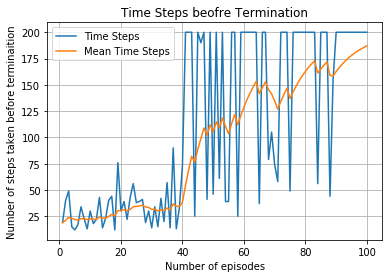

In [14]:
plt.plot(list(range(1, len(timesteps) + 1)), timesteps, label='Time Steps')
plt.plot(list(range(1, len(mean_steps) + 1)), mean_steps, label='Mean Time Steps')
plt.title('Time Steps beofre Termination')
plt.xlabel('Number of episodes')
plt.ylabel('Number of steps taken before terminaition')
plt.legend()
plt.grid()
plt.show()

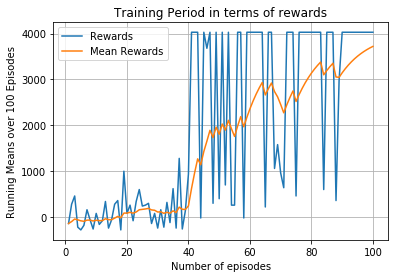

In [15]:
plt.plot(list(range(1, len(rewards) + 1)), rewards, label='Rewards')
plt.plot(list(range(1, len(means) + 1)), means, label='Mean Rewards')
plt.title('Training Period in terms of rewards')
plt.xlabel('Number of episodes')
plt.ylabel('Running Means over 100 Episodes')
plt.legend()
plt.grid()
plt.show()

### Testing
Testing the performance(Average Reward over 100 Steps).

In [0]:
agent.save('cartpole-ddqn-v2')

In [17]:
rewards = 0
for i in range(1, 101):
  state = env.reset()
  ep_reward = 0
  for timestep in count():
    action = np.argmax(agent.q_model(state.reshape(1, -1))[0])
    state, reward, done, _ = env.step(action)
    ep_reward += reward
    if done: break
  rewards += ep_reward / 100
  print(f'\rEpisode: {i}/100\tReward: {ep_reward}', end='')
print(f'\rAverage Reward over 100 episodes is {rewards:.2f}')

Average Reward over 100 episodes is 200.00


In [0]:
env = wrap_env(gym.make(ENV_NAME))
agent = Agent(env.observation_space.shape, env.action_space.n)
agent.q_model.load_weights('cartpole-ddqn-v2-q-model-weights.h5')

In [16]:
state = env.reset()
done = False

while not done:
  env.render()
  action = np.argmax(agent.q_model(state.reshape(1, -1))[0])
  state, _, done, _ = env.step(action)
show_video()